In [42]:
import matplotlib.pyplot as plt
import numpy as np
import myutils
import dataset_utils
import models.SSD_rank_matching as SSD_rank_matching
import mxnet as mx
import ssd_utils_test

In [186]:
back_bone_path = r'd:/Documents/Data_Files/Parameters/'
ssd = SSD_rank_matching.SSD(back_bone_path)
root_path = r'D:/Documents/Data_Files/Datasets/Pascal/VOC2012/'
dataset = dataset_utils.Dataset(root_path)
mx_dataset = dataset.transform(ssd.get_transform_fn())
anchors = ssd.get_anchors()
anchors = mx.nd.array(anchors).expand_dims(axis=0)

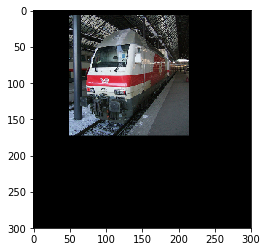

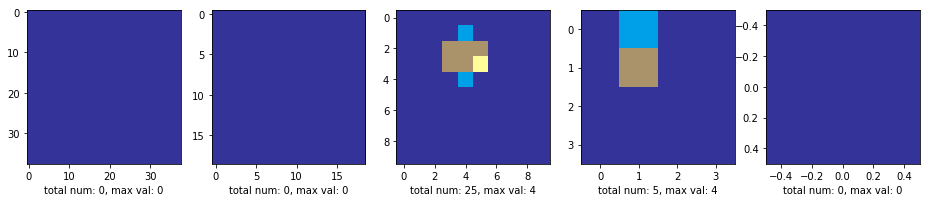

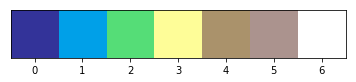

In [187]:
idx = 9
img = dataset[idx]
mx_img, mx_label = mx_dataset[idx]
mx_img = mx_img.expand_dims(axis=0)
mx_label = mx_label.expand_dims(axis=0)
tensor_preds = ssd(mx_img)
cls_preds = tensor_preds[:, :, :21]
gt_boxes = mx_label[:, :, -4:]
gt_ids = mx_label[:, 0:1]
tensor_targs = SSD_rank_matching.generate_target(anchors, cls_preds, gt_boxes, gt_ids)
cls_targs, box_targs, pos_neg_samples = tensor_targs

plt.imshow(myutils.denormalize(mx_img[0].transpose((1, 2, 0)).asnumpy()))
plt.show()

pos_for_anchors = []
for ith_anchor in range(6):
    pos_for_anchor = ssd_utils_test.unreval_anchors(pos_neg_samples[0] > 0, ssd.get_feature_map_shapes_list(), ith_anchor=ith_anchor)
    pos_for_anchors.append(pos_for_anchor)
    
pos_for_feats = [[] for i in range(5)]
for jth_feat in range(5):
    for ith_anchor in range(6):
        pos_for_feats[jth_feat].append(pos_for_anchors[ith_anchor][jth_feat])
        
for ith_feat in range(5):
    pos_for_feat = []
    for jth_anchor in range(6):
        pos_for_feat.append(pos_for_feats[ith_feat][jth_anchor])
    pos_for_feat = np.array(pos_for_feat)
    pos_for_feat = np.sum(pos_for_feat, axis=0)
    pos_for_feats[ith_feat] = pos_for_feat
    
fig, axes = plt.subplots(nrows=1, ncols=5)
for ith_feat in range(5):
    axes[ith_feat].imshow(pos_for_feats[ith_feat], cmap=plt.get_cmap('terrain'), vmin=0, vmax=6)
    axes[ith_feat].set_xlabel('total num: %d, max val: %d' % (np.sum(pos_for_feats[ith_feat]), pos_for_feats[ith_feat].max()))
fig.set_figwidth(16)
fig.set_figheight(3.7)
Fig = fig
plt.show()


grad = np.linspace(0, 6, 7)
grads = np.vstack([grad, grad])
plt.imshow(grads, cmap=plt.get_cmap('terrain'))
ax = plt.gca()
ax.set_ylim(0, 1)
yaxis = ax.get_yaxis()
yaxis.set_visible(False)
plt.show()

In [182]:
Fig.set_tight_layout(True)
Fig.savefig('train.png')

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import myutils
import dataset_utils
import models.SSD_rank_matching as SSD_rank_matching
import mxnet as mx
import ssd_utils_test
import cv2

In [2]:
back_bone_path = r'd:/Documents/Data_Files/Parameters/'
ssd = SSD_rank_matching.SSD(back_bone_path)
ssd.load_parameters(r'd:/Documents/Data_Files/Parameters/rank_matching_param')

In [3]:
pic_1_path = r'D:\Documents\Data_Files\Datasets\pedestrian_detection_dataset\office\input\in000018.jpg'
pic_2_path = r'D:\Documents\Data_Files\Datasets\pedestrian_detection_dataset\office\input\in001248.jpg'
pic_1 = plt.imread(pic_1_path)
pic_2 = plt.imread(pic_2_path)

# 办公室场景对比

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


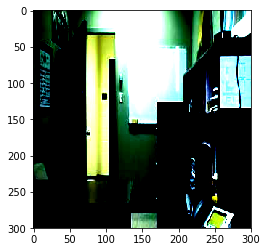

(1, 3, 300, 300)


In [4]:
mx_pic_1 = myutils.normalize(pic_1 / 255)
mx_pic_1 = mx.nd.array(mx_pic_1)  # (h, w, c)
mx_pic_1 = mx.img.imresize(mx_pic_1, w=300, h=300)  # (300, 300, 3)
plt.imshow(mx_pic_1.asnumpy())
plt.show()
mx_pic_1 = mx.nd.transpose(mx_pic_1, axes=(2, 0, 1))  # (3, 300, 300)
mx_pic_1 = mx.nd.expand_dims(mx_pic_1, axis=0)
print(mx_pic_1.shape)

In [5]:
feat_list_1 = []
end = len(ssd.features)
for i in range(end-4, end+1):
    feat_list_1.append(ssd.features[:i](mx_pic_1))
feat_list_1_temp = []
for i in range(5):
    feat_temp = feat_list_1[i]
    feat_temp = mx.nd.mean(feat_temp, axis=1)
    feat_list_1_temp.append(feat_temp[0].asnumpy())
feat_list_1 = feat_list_1_temp
print(feat_list_1[0].shape)

(38, 38)


In [6]:
maximum = 0
minimum = 0
for i in range(5):
    if feat_list_1[i].max() > maximum:
        maximum = feat_list_1[i].max()
    if feat_list_1[i].min() < minimum:
        minimum = feat_list_1[i].min()

In [9]:
maximum

0.55577624

In [8]:
minimum

-0.22188267

C:\IntelPython3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


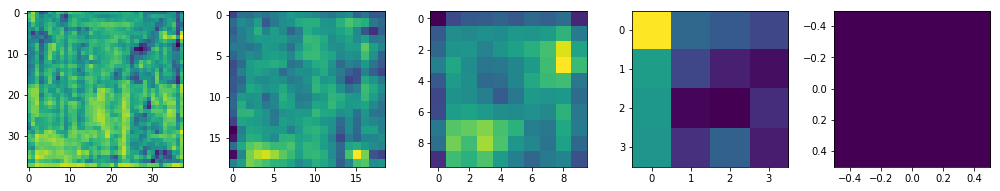

In [21]:
fig_1, ax = plt.subplots(nrows=1, ncols=5)
for i in range(5):
    ax[i].imshow(feat_list_1[i])
fig_1.set_figwidth(14)
fig_1.set_figheight(3)
fig_1.set_tight_layout(True)
fig_1.savefig('pic_1.png')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


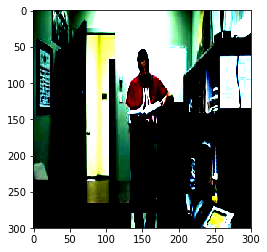

(1, 3, 300, 300)


In [13]:
mx_pic_2 = myutils.normalize(pic_2 / 255)
mx_pic_2 = mx.nd.array(mx_pic_2)  # (h, w, c)
mx_pic_2 = mx.img.imresize(mx_pic_2, w=300, h=300)  # (300, 300, 3)
plt.imshow(mx_pic_2.asnumpy())
plt.show()
mx_pic_2 = mx.nd.transpose(mx_pic_2, axes=(2, 0, 1))  # (3, 300, 300)
mx_pic_2 = mx.nd.expand_dims(mx_pic_2, axis=0)
print(mx_pic_2.shape)

In [14]:
feat_list_2 = []
end = len(ssd.features)
for i in range(end-4, end+1):
    feat_list_2.append(ssd.features[:i](mx_pic_2))
feat_list_2_temp = []
for i in range(5):
    feat_temp = feat_list_2[i]
    feat_temp = mx.nd.mean(feat_temp, axis=1)
    feat_list_2_temp.append(feat_temp[0].asnumpy())
feat_list_2 = feat_list_2_temp
print(feat_list_2[0].shape)

(38, 38)


C:\IntelPython3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


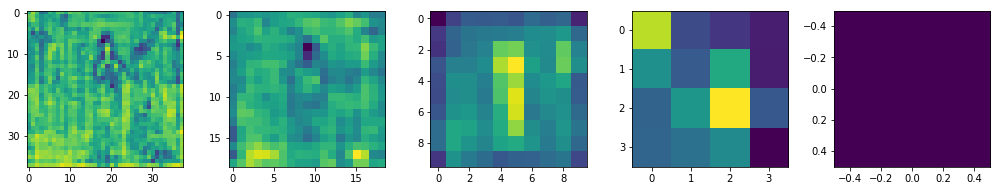

In [22]:
fig_2, ax = plt.subplots(nrows=1, ncols=5)
for i in range(5):
    ax[i].imshow(feat_list_2[i])
fig_2.set_figwidth(14)
fig_2.set_figheight(3)
fig_2.set_tight_layout(True)
fig_2.savefig('pic_2.png')
plt.show()

In [23]:
tensor_pred = ssd(mx_pic_2)

In [25]:
cls_scr_box = SSD_rank_matching.get_pred_scores_classes_and_boxes(tensor_pred, mx.nd.array(ssd.get_anchors()).expand_dims(axis=0))

In [31]:
cls_scr_box[0]

array([[ 0.9839522 , 14.        ,  0.4179608 ,  0.12581545,  0.5840225 ,
         0.9572696 ],
       [ 0.88194925, 14.        ,  0.40812257,  0.18537673,  0.6332926 ,
         0.59726965]], dtype=float32)

In [43]:
bg_prob = tensor_pred[0, :, :21].softmax(axis=1)[:, 0]
scr_idx = mx.nd.argsort(bg_prob)

In [63]:
cls_list = []
for idx in scr_idx[:200]:
    cls_list.append(int(mx.nd.argmax(tensor_pred[0, int(idx.asscalar()), :21], axis=0).asscalar()))

In [65]:
plt.hist(cls_list)

(array([143.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

In [66]:
143/200

0.715

In [67]:
57/200

0.285

# 降噪滤波

C:\IntelPython3\lib\site-packages\matplotlib\figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


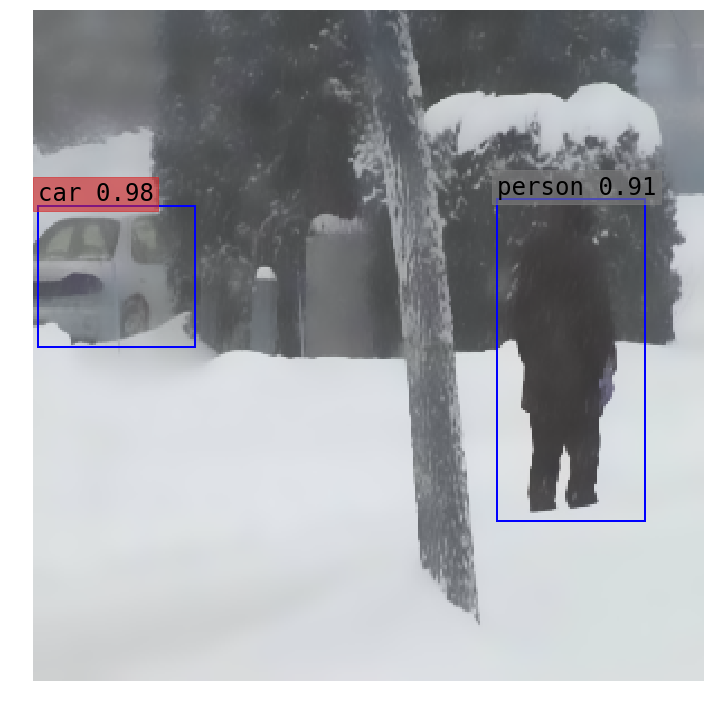

In [167]:
img = cv2.imread('d:/in000068.jpg')
img = cv2.resize(img, (300, 300))

img = cv2.bilateralFilter(img, 15, 75, 75)
plt.imshow(img)
plt.show()